<a href="https://colab.research.google.com/github/shaiksameer46/Volatility-Surfaces/blob/main/Local%20Volatility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# getting all maturity dates available for a particular stock option
ticker_symbol = "AAPL"
maturities = list(yf.Ticker(ticker_symbol).options)
maturities

['2023-12-08',
 '2023-12-15',
 '2023-12-22',
 '2023-12-29',
 '2024-01-05',
 '2024-01-12',
 '2024-01-19',
 '2024-02-16',
 '2024-03-15',
 '2024-04-19',
 '2024-06-21',
 '2024-07-19',
 '2024-09-20',
 '2024-12-20',
 '2025-01-17',
 '2025-06-20',
 '2025-09-19',
 '2025-12-19',
 '2026-01-16']

In [ ]:
strikes = list(yf.Ticker(ticker_symbol).option_chain(maturities[1]).calls["strike"])
# strikes

In [ ]:
call_prices = yf.Ticker(ticker_symbol).option_chain(maturities[1]).calls
# call_prices

In [ ]:
def get_call_price(strike, maturity):
  calls = yf.Ticker(ticker_symbol).option_chain(maturity).calls
  try:
    call_value = calls[calls['strike'] == strike].lastPrice
    return call_value
  except Exception as e:
    return 0

In [ ]:
def get_numerator_value(calls_df, deltaT):
  calls_diff = pd.DataFrame()
  for i in range(len(deltaT)):
    calls_diff[i] = pd.DataFrame((calls_df.iloc[:, i+2] - calls_df.iloc[:, i+1]).div(deltaT[i]))
  calls_diff = calls_diff*2
  return calls_diff

In [ ]:
def get_denominator_value(calls_df):
  denominator_df = pd.DataFrame()
  for i in range(1, calls_df.shape[0] -1):
    denominator_df = denominator_df.append((((calls_df.iloc[i-1] + calls_df.iloc[i+1] - 2*calls_df.iloc[i]) /
    ((calls_df["Strike"][i] - calls_df["Strike"][i-1])**2))*calls_df["Strike"][i]**2), ignore_index=True)
  return denominator_df

In [ ]:
strikes = [125.0, 130.0, 135.0, 140.0, 145.0, 150.0, 155.0, 160.0, 165.0, 170.0, 175.0, 180.0, 185.0, 190.0, 195.0, 200.0, 205.0, 210.0, 215.0, 220.0,
           225.0, 230.0, 235.0, 240.0]
call_list = []
deltaT = []
call_list.append(strikes)
maturity = ['2023-12-08', '2023-12-15', '2023-12-22', '2023-12-29', '2024-01-19']
for i in maturity:
  temp_list = []
  for j in strikes:
    temp_list.append(get_call_price(j, i))
  temp_list = [float(value) if(len(value) > 0) else 0  for value in temp_list]
  call_list.append(temp_list)

In [ ]:
for i in range(len(maturity[:-1])):
  deltaT.append(len(pd.date_range(pd.to_datetime(maturity[i]), pd.to_datetime(maturity[i+1]), freq='B')))

In [ ]:
# call prices df for expected strikes and maturities
calls_df = pd.DataFrame(call_list).transpose()
calls_df.columns = ['Strike', '2023-12-08', '2023-12-15', '2023-12-22', '2023-12-29', '2024-01-19']

In [ ]:
# fetching numerical value
numerator_df = get_numerator_value(calls_df, deltaT)
numerator_df.drop([0, len(numerator_df) - 1], inplace=True)
numerator_df.reset_index(drop=True, inplace=True)
# numerator_df

In [ ]:
# fetching denominator value
denominator_df = get_denominator_value(calls_df)
denominator_df.drop(columns = ['Strike', '2024-01-19'], inplace=True)
denominator_df.columns = [0,1,2,3]
# denominator_df

In [ ]:
# local volatility for strikes and maturities considered
vol_df = np.sqrt(numerator_df/denominator_df)
vol_df.replace(np.inf, np.NaN, inplace=True)
vol_df = vol_df.apply(lambda row: row.fillna(row.mean()), axis=1)
vol_df.set_index(pd.Index(strikes[1:-1]), inplace=True)
vol_df.columns = [8,15,22,29] # all the dates in the month of december

In [ ]:
# column names are date value in dec 2023
vol_df

,8,15,22,29
130.0,0.016454,0.010231,0.013342,0.013342
135.0,0.058209,0.107627,0.058209,0.008790
140.0,0.015668,0.010410,0.010410,0.005152
145.0,0.050404,0.125124,0.015072,0.011015
150.0,0.017399,0.072008,0.016068,0.005195
155.0,0.009411,0.011537,0.018761,0.006440
160.0,0.006891,0.010417,0.006270,0.003987
165.0,0.025214,0.015784,0.015784,0.006354
170.0,0.100460,0.037382,0.015864,0.006436
175.0,0.011826,0.011826,0.006156,0.017496


In [ ]:
x, y = np.meshgrid(vol_df.columns, vol_df.index)
z = vol_df.values

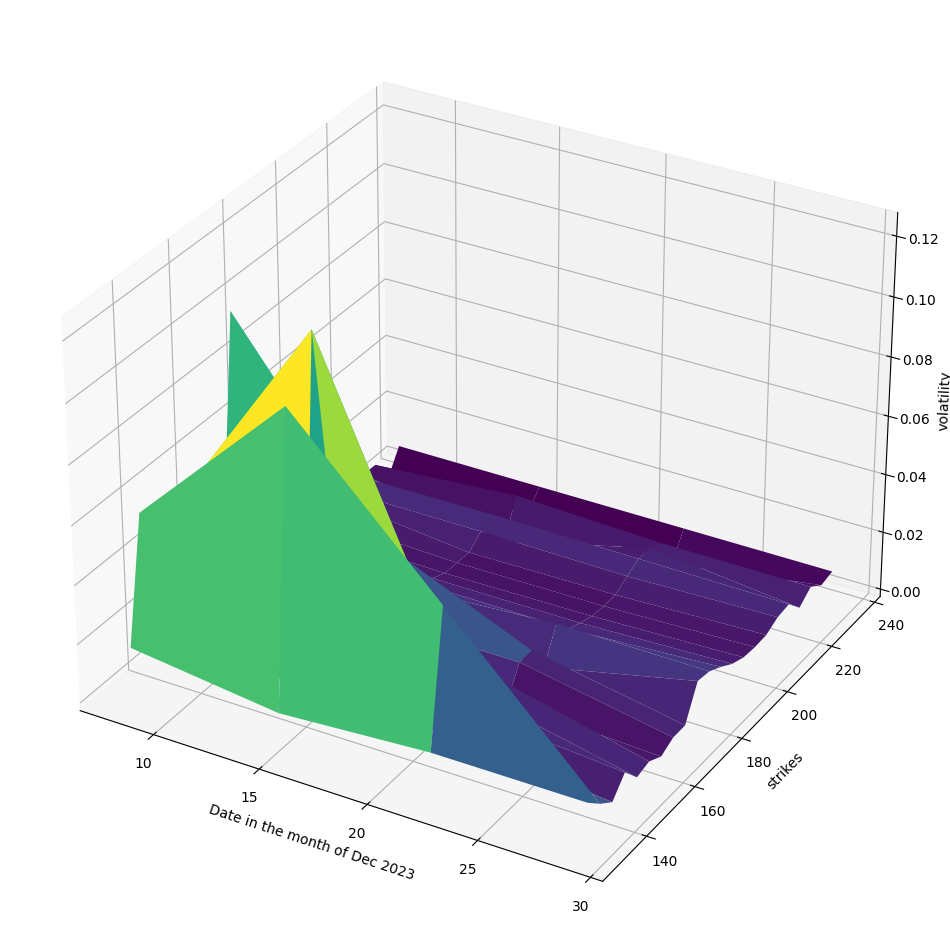

In [ ]:
fig = plt.figure(figsize=(12, 15))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(x, y, z, cmap='viridis')

# Set labels for the axes
ax.set_xlabel('Date in the month of Dec 2023')
ax.set_ylabel('strikes')
ax.set_zlabel('volatility')

# Display the plot
plt.show()